In [49]:
import numpy as np
import pandas as pd
import gc
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.signal import lombscargle
import math
from tqdm import tqdm

In [50]:
# some help functions
# angular frequency to period
def freq2Period(w):
    return 2 * math.pi / w
# period to angular frequency
def period2Freq(T):
    return 2 * math.pi / T

In [51]:
gc.enable()
train = pd.read_csv('all/training_set.csv')
print(train['object_id'].unique())
gc.collect()

[      615       713       730 ... 130762946 130772921 130779836]


488

In [ ]:
def processData(train, object_id):
    
    #load data for given object
    X = train.loc[train['id'] == object_id]
    x = np.array(X['mjd'].values)
    y = np.array(X['flux'].values)
    passband = np.array(X['passband'].values)
    
    # normalize bands
    for i in np.unique(passband):
        yy = y[np.where(passband==i)]
        mean = np.mean(yy)
        std = np.std(yy)
        y[np.where(passband==i)] = (yy - mean)/std
    
    return x, y, passband

In [ ]:

x, y, passband = processData(train, 0)
plt.scatter(x, y, c=passband)
plt.xlabel('time (MJD)')
plt.ylabel('Normalized flux')
plt.show()

In [18]:
def getPeriodogram(x, y, steps = 10000, minPeriod = None, maxPeriod = None):
    if not minPeriod:
        minPeriod = 0.1 # for now, let's ignore very short periodic objects
    if not maxPeriod:
        maxPeriod = (np.max(x) - np.min(x))/2 # you cannot detect P > half of your observation period

    maxFreq = np.log2(period2Freq(minPeriod))
    minFreq = np.log2(period2Freq(maxPeriod))
    f = np.power(2, np.linspace(minFreq,maxFreq, steps))
    p = lombscargle(x,y,f,normalize=True)
    return f, p

In [19]:
def findBestPeaks(x, y, F, P, threshold=0.3, n=5):
    
    # find peaks above threshold
    indexes = np.where(P>threshold)[0]
    # if nothing found, look at the highest peaks anyway
    if len(indexes) == 0:
        q = np.quantile(P, 0.9995)
        indexes = np.where(P>q)[0]
    
    peaks = []
    start = 0
    end = 0
    for i in indexes:
        if i - end > 10:
            peaks.append((start, end))
            start = i
            end = i
        else:
            end = i
    
    peaks.append((start, end))
        
    
    # increase accuracy on the found peaks
    results = []
    for start, end in peaks:
        if end > 0:
            minPeriod = freq2Period(F[min(F.shape[0]-1, end+1)])
            maxPeriod = freq2Period(F[max(start-1, 0)])
            steps = int(100 * np.sqrt(end-start+1)) # the bigger the peak width, the more steps we want - but sensible (linear increase leads to long computation)
            f, p = getPeriodogram(x, y, steps = steps, minPeriod=minPeriod, maxPeriod=maxPeriod)
            results.append(np.array([freq2Period(f[np.argmax(p)]), np.max(p)]))

    # sort by normalized periodogram score and return first n results
    if results:
        results = np.array(results)
        results = results[np.flip(results[:,1].argsort())]
    else:
        results = np.array([freq2Period(F[np.argmax(P)]), np.max(P)]).reshape(1,2)
    return results[0:n]

In [23]:
def getStats(series):
    x = np.array(series['mjd'].values)
    y = np.array(series['flux'].values)
    passband = np.array(series['passband'].values)
    
    # normalize bands
    for i in np.unique(passband):
        yy = y[np.where(passband==i)]
        mean = np.mean(yy)
        std = np.std(yy)
        y[np.where(passband==i)] = (yy - mean)/std
    
    
    f,p = getPeriodogram(x, y, steps=20000)
    peaks = findBestPeaks(x, y, f, p)
    features = np.zeros((5,2))
    features[:peaks.shape[0],:peaks.shape[1]] = peaks
    
    return  (np.append(np.array([id]), features.reshape(5*2)))

from multiprocessing import Pool
import multiprocessing as mp

CORES = mp.cpu_count() #4

peaks = train.groupby("object_id").apply(getStats)
peaks

KeyboardInterrupt: 

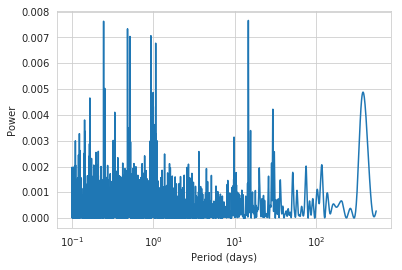

In [56]:
plt.semilogx(freq2Period(f),p)
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.show()

In [31]:
import numpy as np
import pandas as pd
import matplotlib
from scipy import stats
import matplotlib.pyplot as plt
from collections import Counter

def process_flux_agg(df):
    flux_diff = df['flux_max_encod'].values - df['flux_min_encod'].values
    
    df_flux_agg = pd.DataFrame({
        'flux_diff1': flux_diff,
        'flux_diff2': flux_diff / df['flux_mean_encod'].values}, index=df.index)
    
    return pd.concat([df, df_flux_agg], axis=1)
# General aggregates
from tsfresh.feature_extraction import extract_features
# Features to compute with tsfresh library. Fft coefficient is meant to capture periodicity


aggs_all = {
        'flux': ['min', 'max', 'mean', 'median', 'std', 'skew'],
    }

aggs_pb = {
        'flux': ['min', 'max', 'mean', 'median', 'std', 'skew'],

    }

fcp = {                     
        'flux_passband': {
            'kurtosis' : None, 
            'skewness' : None,
        }
    }

def featurize(df, n_jobs=8):
    """
    Extracting Features from train set
    Features from olivier's kernel
    very smart and powerful feature that is generously given here https://www.kaggle.com/c/PLAsTiCC-2018/discussion/69696#410538
    per passband features with tsfresh library. fft features added to capture periodicity https://www.kaggle.com/c/PLAsTiCC-2018/discussion/70346#415506
    """
    
    agg_df1 = df.groupby(['object_id']).agg(aggs_all)

    agg_df2 = df.groupby(['object_id','passband']).agg(aggs_pb)
    agg_df2 = agg_df2.unstack(level=-1)

    agg_df1.columns = [ '{}_{}_encod'.format(k, agg) for k in aggs_all.keys() for agg in aggs_all[k]]
    agg_df2.columns = [ '{}_{}_{}_encod'.format(k, agg,p) for k in aggs_pb.keys() for agg in aggs_pb[k] for p in range(0,6)]
    agg_df1 = process_flux_agg(agg_df1) # new feature to play with tsfresh
    
    # Add more features with
    agg_df_ts_flux_passband = extract_features(df, 
                                               column_id='object_id', 
                                               column_sort='mjd', 
                                               column_kind='passband', 
                                               column_value='flux', 
                                               default_fc_parameters=fcp['flux_passband'], n_jobs=n_jobs)


    # Add smart feature that is suggested here https://www.kaggle.com/c/PLAsTiCC-2018/discussion/69696#410538
    # dt[detected==1, mjd_diff:=max(mjd)-min(mjd), by=object_id]
    
    agg_df_ts_flux_passband.index.rename('object_id', inplace=True) 

    agg_df_ts = pd.concat([agg_df1, 
                           agg_df2,
                           agg_df_ts_flux_passband                           
                           ], axis=1).reset_index()
   
    return agg_df_ts
"""
agg_train = featurize(train)
agg_train.drop("index",axis=1,inplace=True)
agg_train.to_csv("train/neg_flux/agg_train_autoenc.csv")
"""

'\nagg_train = featurize(train)\nagg_train.drop("index",axis=1,inplace=True)\nagg_train.to_csv("train/neg_flux/agg_train_autoenc.csv")\n'

In [15]:
agg_train

,flux_min_encod,flux_max_encod,flux_mean_encod,flux_median_encod,flux_std_encod,flux_skew_encod,flux_diff1,flux_diff2,flux_min_0_encod,flux_min_1_encod,...,1.0__kurtosis,1.0__skewness,2.0__kurtosis,2.0__skewness,3.0__kurtosis,3.0__skewness,4.0__kurtosis,4.0__skewness,5.0__kurtosis,5.0__skewness
0,1.251828e+02,661.626343,434.258877,414.345398,175.302017,-0.384413,536.443535,1.235308,1.251828e+02,6.606263e+02,...,-1.629353,5.415376e-01,-1.400086,7.264563e-01,-1.349070,7.531514e-01,1.286499,1.780683e+00,-0.961555,9.808281e-01
1,4.011444e+00,13.845472,7.683726,6.344858,3.468925,0.533515,9.834028,1.279852,4.737393e+00,6.952323e+00,...,-1.499191,6.440304e-01,-1.302994,7.821372e-01,-1.378617,7.396648e-01,1.361939,1.805035e+00,-0.458776,1.197168e+00
2,2.530638e+00,15.770886,8.239407,9.134171,4.380620,0.139723,13.240248,1.606942,3.348282e+00,3.545214e+00,...,-1.913095,2.545466e-03,-1.958521,1.287502e-03,-1.961793,4.520380e-04,-1.954725,2.670775e-03,-1.926973,5.957179e-03
3,2.483539e+00,48.310059,15.505437,5.970370,15.730628,0.995825,45.826519,2.955513,3.110694e+00,3.564052e+00,...,-1.524494,3.325748e-02,-1.993506,1.544181e-04,-1.998700,-6.281118e-06,-2.000458,2.258646e-05,-1.999886,9.312298e-05
4,2.334581e+00,221.795212,87.974083,40.822909,87.853611,0.373852,219.460631,2.494606,3.093587e+00,3.585434e+00,...,-2.001741,8.360498e-07,-2.001766,7.164828e-07,-2.001754,-4.301664e-07,-2.001751,6.154467e-07,-2.001468,1.603322e-05
5,2.631665e+00,144.600189,48.345197,11.383690,55.852943,0.732534,141.968524,2.936559,3.658313e+00,3.731154e+00,...,-1.999100,3.205718e-05,-2.001556,3.213107e-06,-2.001671,-8.997952e-07,-2.001720,9.988424e-07,-2.001557,1.201458e-05
6,2.485458e+00,72.678154,12.504455,4.304930,18.591523,2.682979,70.192696,5.613415,3.109235e+00,3.560404e+00,...,-1.870146,4.518660e-03,-0.826233,4.517884e-01,-0.798447,3.377328e-01,-1.981263,8.285558e-04,-1.939282,4.776107e-03
7,3.585604e+00,1449.715698,454.827084,144.237851,527.267256,0.693768,1446.130094,3.179516,3.585604e+00,8.624741e+00,...,-2.001827,1.890486e-08,-2.001827,2.290843e-08,-2.001826,-1.605678e-08,-2.001825,1.320402e-08,-2.001822,2.792267e-07
8,2.611106e+00,35.559826,9.352491,5.280550,8.709617,2.021875,32.948720,3.522989,3.632440e+00,3.695240e+00,...,-1.204812,8.646596e-02,-1.235485,9.634463e-02,-1.894259,2.601301e-03,-1.959811,2.241641e-03,-1.997130,2.408746e-04
9,2.697659e+00,232.828339,91.449271,43.159845,93.783926,0.378792,230.130680,2.516485,3.402587e+00,3.630055e+00,...,-2.001744,8.092151e-07,-2.001772,6.463881e-07,-2.001768,-3.574509e-07,-2.001771,4.462634e-07,-2.001481,1.544337e-05


In [16]:
agg_train = pd.read_csv("train/neg_flux/agg_train_autoenc.csv")

In [102]:
aggs_all = {
        'flux': ['min', 'max', 'mean', 'median', 'std', 'skew'],
        'flux_err': ['min', 'max', 'mean', 'median', 'std', 'skew'],
        'detected': ['mean']
}
    
from itertools import islice

def sxedio5(series):
    threshold = 102
    diffs = np.diff(series.mjd)
    diff_ids = (np.where(diffs>threshold))
        
    if(len(diff_ids[0])==2):
        series1 = series[:diff_ids[0][0]]
        series2 = series[diff_ids[0][0]:diff_ids[0][1]]
        series3 = series[diff_ids[0][1]:]
        
        agg1 = series1.agg(aggs_all)
        agg2 = series2.agg(aggs_all)
        agg3 = series3.agg(aggs_all)

        aggs = pd.concat([agg1, agg2, agg3], axis=1)
    elif(len(diff_ids[0])==3):
        series1 = series[:diff_ids[0][0]]
        series2 = series[diff_ids[0][0]:diff_ids[0][1]]
        series3 = series[diff_ids[0][1]:diff_ids[0][2]]
        series4 = series[diff_ids[0][2]:]

        agg1 = series1.agg(aggs_all)
        agg2 = series2.agg(aggs_all)
        agg3 = series3.agg(aggs_all)
        agg4 = series4.agg(aggs_all)

        aggs = pd.concat([agg1, agg2, agg3, agg4], axis=1)
    else:
        mjd_diff = np.max(series.mjd) - np.min(series.mjd)
        mjd_diff_div =int(np.ceil(mjd_diff/4))
        #print(mjd_diff, mjd_diff_div)
        series1 = series[:mjd_diff_div]
        series2 = series[mjd_diff_div:2*mjd_diff_div]
        series3 = series[2*mjd_diff_div:3*mjd_diff_div]
        series4 = series[3*mjd_diff_div:]
       
        
        agg1 = series1.agg(aggs_all)
        agg2 = series2.agg(aggs_all)
        agg3 = series3.agg(aggs_all)

        aggs = pd.concat([agg1, agg2, agg3], axis=1)
    if(aggs.shape == (6,9)):
        agg1[:] = 0
        #print(agg1)
        aggs = pd.concat([aggs,agg1],axis=1)
    return aggs   
    
    
    
diffs = train.groupby("object_id").apply(sxedio5)
diffs

flux    flux_err  detected         flux    flux_err  \
object_id                                                                       
615       max       659.486694   11.395031       NaN   660.626343   12.845472   
          mean     -230.643313    4.457957  0.975207   -91.385241    4.611389   
          median   -310.010925    3.736262       NaN   -35.149330    3.908728   
          min     -1100.440063    2.130510       NaN -1098.651489    2.498579   
          skew        0.199586    1.600908       NaN    -0.590265    1.841557   
          std       385.186195    1.775954       NaN   408.158904    1.793390   
713       max        14.509829    9.115748       NaN    14.770886    6.829591   
          mean        4.163086    2.275422  0.088710     0.124486    2.482207   
          median      4.118353    1.859288       NaN    -0.190900    2.058085   
          min        -9.332252    0.639458       NaN   -12.699218    0.746168   
          skew       -0.482157    1.863336       NaN     0.096456    1.351185   
          std         3.725186    1.543285       NaN     4.571270    1.535557   
730       max        11.777126    7.966248       NaN     9.333996   11.281384   
          mean        0.239381    2.413239  0.000000    -0.474544    2.704284   
          median      0.106692    1.919590       NaN    -0.059840    2.176772   
          min       -12.809639    0.695106       NaN   -19.159811    0.766401   
          skew        0.327705    1.598324       NaN    -1.380116    1.942921   
          std         2.822747    1.660278       NaN     3.843007    1.933237   
745       max        12.491076    8.552037       NaN   220.795212   11.663839   
          mean       -0.018037    2.243641  0.000000    29.707504    2.504877   
          median      0.096551    1.730223       NaN    14.269365    1.910771   
          min       -10.249387    0.600194       NaN    -3.003068    0.653086   
          skew        0.101126    1.690359       NaN     2.712962    2.175164   
          std         2.773487    1.634371       NaN    43.730811    1.939754   
1124      max        11.112542   10.423373       NaN    10.835242   11.383690   
          mean        0.091815    2.674462  0.000000     0.252414    2.833543   
          median      0.528071    2.157105       NaN     0.249013    2.323670   
          min       -16.543753    0.752658       NaN    -9.061588    0.727991   
          skew       -1.378127    1.882437       NaN    -0.048503    1.873459   
          std         3.206350    1.966662       NaN     2.796379    2.000914   
...                        ...         ...       ...          ...         ...   
130739978 max       517.602478   72.230759       NaN   110.275200   62.952652   
          mean        8.498795   15.206631  0.043478     8.456808   19.269700   
          median     -0.502545    8.724419       NaN     6.390925   14.866217   
          min       -94.448326    1.700991       NaN   -38.782394    1.814235   
          skew        5.972436    1.810101       NaN     1.930054    1.236868   
          std        79.856247   14.886907       NaN    24.560610   15.746396   
130755807 max        67.810570   71.215874       NaN   363.402466   56.018307   
          mean        0.292497   25.571656  0.000000    44.396057   17.152040   
          median      2.751645   23.795499       NaN     3.082341   14.574579   
          min       -69.036392    7.308864       NaN   -44.086132    2.326328   
          skew       -0.227906    1.514892       NaN     2.247390    1.082032   
          std        27.420654   15.944463       NaN   103.881712   12.937550   
130762946 max        60.889641   79.265930       NaN   169.916672   69.014053   
          mean      -13.903469   32.139481  0.035714   -11.624030   25.649272   
          median    -11.012358   28.425717       NaN   -15.315082   21.736277   
          min       -90.300354    7.322531       NaN   -87.010033    5.974091   
          skew       -0.082250    1.052531       NaN     

In [106]:
diffs2 = diffs.unstack(level=-1)
new_columns = [
            "new_feats" + str(i)  for i in range(72)
        ]
diffs2.columns = new_columns
diffs2

,new_feats0,new_feats1,new_feats2,new_feats3,new_feats4,new_feats5,new_feats6,new_feats7,new_feats8,new_feats9,...,new_feats62,new_feats63,new_feats64,new_feats65,new_feats66,new_feats67,new_feats68,new_feats69,new_feats70,new_feats71
object_id,,,,,,,,,,,,,,,,,,,,,
615,659.486694,-230.643313,-310.010925,-1100.440063,0.199586,385.186195,11.395031,4.457957,3.736262,2.130510,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
713,14.509829,4.163086,4.118353,-9.332252,-0.482157,3.725186,9.115748,2.275422,1.859288,0.639458,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
730,11.777126,0.239381,0.106692,-12.809639,0.327705,2.822747,7.966248,2.413239,1.919590,0.695106,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
745,12.491076,-0.018037,0.096551,-10.249387,0.101126,2.773487,8.552037,2.243641,1.730223,0.600194,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1124,11.112542,0.091815,0.528071,-16.543753,-1.378127,3.206350,10.423373,2.674462,2.157105,0.752658,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1227,8.092285,-0.161867,0.118753,-12.695161,-1.300771,2.907066,8.353500,2.542712,2.003150,0.720329,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1598,12.903332,0.170220,0.249740,-11.553727,0.237925,3.063292,10.354021,2.649326,2.121293,0.743951,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1632,34.559826,4.433000,2.273386,-5.074782,2.194903,6.929965,10.393328,2.662764,2.140205,0.748097,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1920,17.435411,-0.104133,0.171616,-13.367912,0.286568,3.978243,8.929063,3.055874,2.508360,0.992744,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


In [107]:
diffs2.to_csv("train/neg_flux/new_feats.csv")